Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result. 

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/iremkry/sr_low
!mv sr_low/* ./

Cloning into 'sr_low'...
remote: Enumerating objects: 350, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 350 (delta 196), reused 287 (delta 169), pack-reused 0
Receiving objects: 100% (350/350), 64.59 MiB | 11.15 MiB/s, done.
Resolving deltas: 100% (196/196), done.


# Import libs

In [52]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from models.downsampler import Downsampler

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1 
factor = 4 # 8
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two (32 in this case)
PLOT = True

# To produce images from the paper we took *_GT.png images from LapSRN viewer for corresponding factor,
# e.g. x4/zebra_GT.png for factor=4, and x8/zebra_GT.png for factor=8 
path_to_image = 'data/sr/smallbw_96_bc.png'

path_to_image_low = 'data/sr/smallbw_96.png'

In [53]:
def load_LR_HR_imgs_sr_low(fname, imsize, factor, enforse_div32=None):
    '''Loads an image, resizes it, center crops and downscales.
    Args: 
        fname: path to the image
        imsize: new size for the image, -1 for no resizing
        factor: downscaling factor
        enforse_div32: if 'CROP' center crops an image, so that its dimensions are divisible by 32.
    '''
    img_orig_pil_low, img_orig_np_low = get_image(fname, -1)

    if imsize != -1:
        img_orig_pil_low, img_orig_np_low = get_image(fname, imsize)
        
    # For comparison with GT
    if enforse_div32 == 'CROP':
        new_size = (img_orig_pil_low.size[0] - img_orig_pil_low.size[0] % 32, 
                    img_orig_pil_low.size[1] - img_orig_pil_low.size[1] % 32)

        bbox = [
                (img_orig_pil_low.size[0] - new_size[0])/2, 
                (img_orig_pil_low.size[1] - new_size[1])/2,
                (img_orig_pil_low.size[0] + new_size[0])/2,
                (img_orig_pil_low.size[1] + new_size[1])/2,
        ]

        img_HR_pil_low = img_orig_pil_low.crop(bbox)
        img_HR_np_low = pil_to_np(img_HR_pil_low)
    else:
        img_HR_pil_low, img_HR_np_low = img_orig_pil_low, img_orig_np_low
        
    LR_size_low = [
               img_HR_pil_low.size[0] // factor, 
               img_HR_pil_low.size[1] // factor
    ]

    img_LR_pil_low = img_HR_pil_low.resize(LR_size_low, Image.ANTIALIAS)
    img_LR_np_low = pil_to_np(img_LR_pil_low)

    print('HR and LR resolutions: %s, %s' % (str(img_HR_pil_low.size), str (img_LR_pil_low.size)))

    return {
                'orig_pil_low': img_orig_pil_low,
                'orig_np_low':  img_orig_np_low,
                'LR_pil_low':  img_LR_pil_low, 
                'LR_np_low': img_LR_np_low,
                'HR_pil_low':  img_HR_pil_low, 
                'HR_np_low': img_HR_np_low
           }


In [54]:
def get_baselines_low(img_LR_pil_low, img_HR_pil_low):
    '''Gets `bicubic`, sharpened bicubic and `nearest` baselines.'''
    img_bicubic_pil_low = img_LR_pil_low.resize(img_HR_pil_low.size, Image.BICUBIC)
    img_bicubic_np_low = pil_to_np(img_bicubic_pil_low)

    img_nearest_pil_low = img_LR_pil_low.resize(img_HR_pil_low.size, Image.NEAREST)
    img_nearest_np_low = pil_to_np(img_nearest_pil_low)

    img_bic_sharp_pil_low = img_bicubic_pil_low.filter(PIL.ImageFilter.UnsharpMask())
    img_bic_sharp_np_low = pil_to_np(img_bic_sharp_pil_low)

    return img_bicubic_np_low, img_bic_sharp_np_low, img_nearest_np_low

# Load image and baselines

HR and LR resolutions: (384, 384), (96, 96)


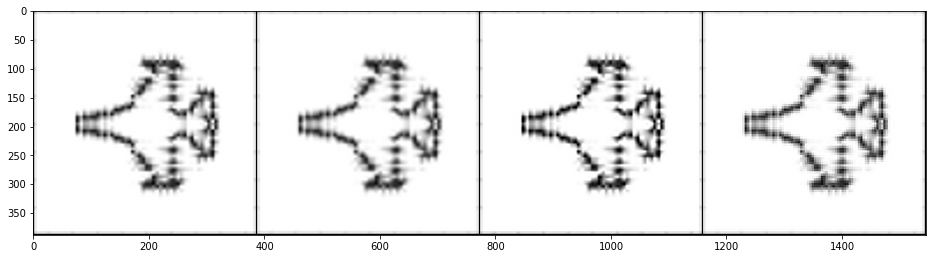

PSNR bicubic: 40.8003   PSNR sharp: 33.9962  PSNR nearest: 29.9417


In [55]:
# Starts here
imgs = load_LR_HR_imgs_sr(path_to_image , imsize, factor, enforse_div32)

imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])

if PLOT:
    plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np']], 4,12);
    print ('PSNR bicubic: %.4f   PSNR sharp: %.4f  PSNR nearest: %.4f' %  (
                                        peak_signal_noise_ratio(imgs['HR_np'], imgs['bicubic_np']), 
                                        peak_signal_noise_ratio(imgs['HR_np'], imgs['sharp_np']),
                                        peak_signal_noise_ratio(imgs['HR_np'], imgs['nearest_np'])))
    
 

In [56]:
imgs_low = load_LR_HR_imgs_sr_low(path_to_image_low , imsize, factor, enforse_div32)
imgs_low['bicubic_np_low'], imgs_low['sharp_np_low'], imgs_low['nearest_np_low'] = get_baselines_low(imgs_low['LR_pil_low'], imgs_low['HR_pil_low'])

if PLOT:
   # plot_image_grid([imgs_low['HR_np_low'], imgs_low['bicubic_np_low'], imgs_low['sharp_np_low'], imgs_low['nearest_np_low']], 4,12);
    print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
                                        peak_signal_noise_ratio(imgs_low['HR_np_low'], imgs_low['bicubic_np_low']), 
                                        peak_signal_noise_ratio(imgs_low['HR_np_low'], imgs_low['nearest_np_low'])))   

HR and LR resolutions: (96, 96), (24, 24)
PSNR bicubic: 20.8650   PSNR nearest: 19.6241


In [57]:
a_o = imgs['orig_np']
a_h = imgs['HR_np']
a_l = imgs['LR_np']
a_p = imgs['orig_pil']
b_o = imgs_low['orig_np_low']
b_h = imgs_low['HR_np_low']
b_l = imgs_low['LR_np_low']
b_p = imgs_low['orig_pil_low']


# Set up parameters and net

In [58]:
input_depth = 16
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

if factor == 4: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

In [59]:
net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

NET_TYPE = 'skip' # UNet, ResNet
net = get_net(input_depth, 'skip', pad,
              skip_n33d=512, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = np_to_torch(imgs_low['orig_np_low']).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

# Define closure and optimize

In [60]:
def closure():
    global i, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
        
    total_loss.backward()

    # Log
    psnr_LR = peak_signal_noise_ratio(imgs_low['orig_np_low'], torch_to_np(out_LR))
    psnr_HR = peak_signal_noise_ratio(imgs['HR_np'], torch_to_np(out_HR))
    print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')

    #print(psnr_LR, psnr_HR) 
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if PLOT and i % 100 == 0:
        out_HR_np = torch_to_np(out_HR)
        plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)

    i += 1
    
    return total_loss

Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


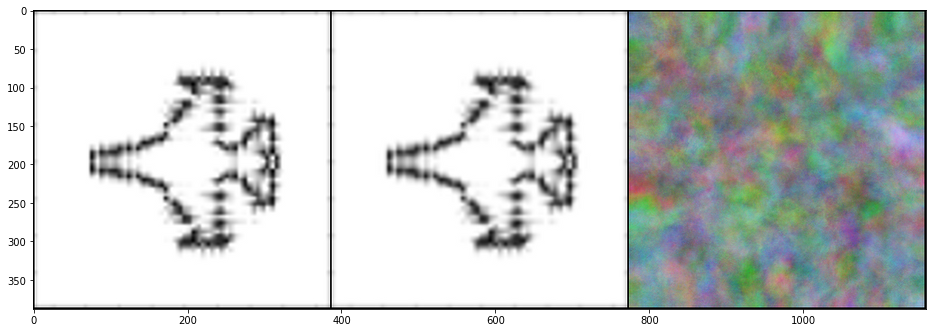

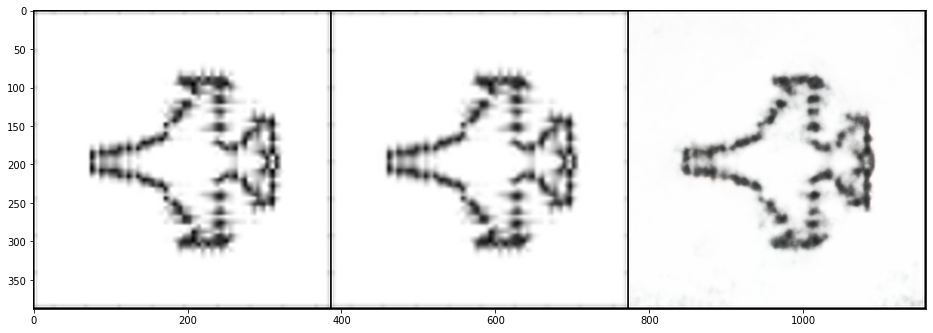

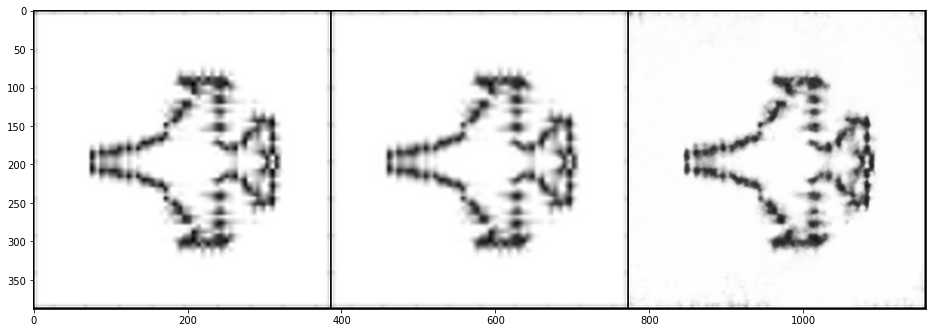

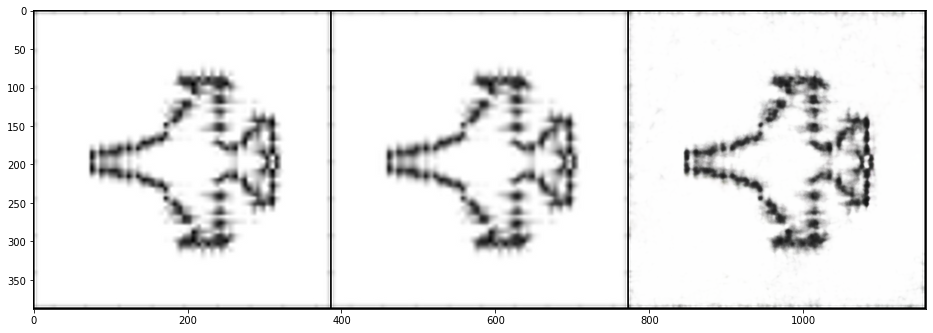

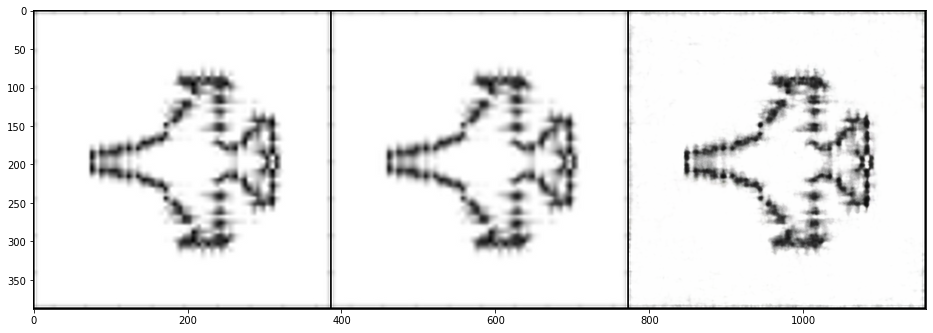

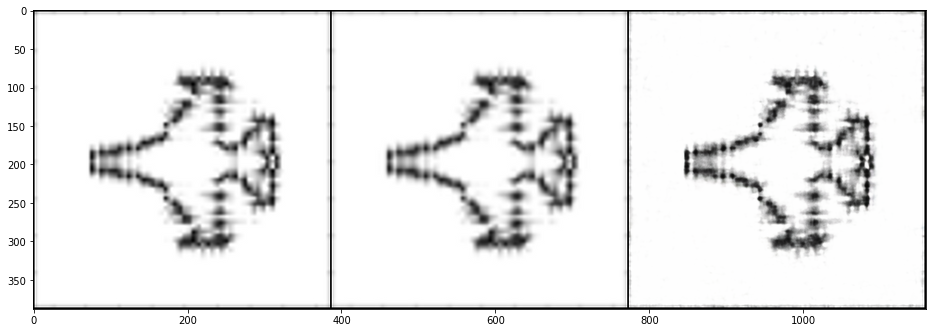

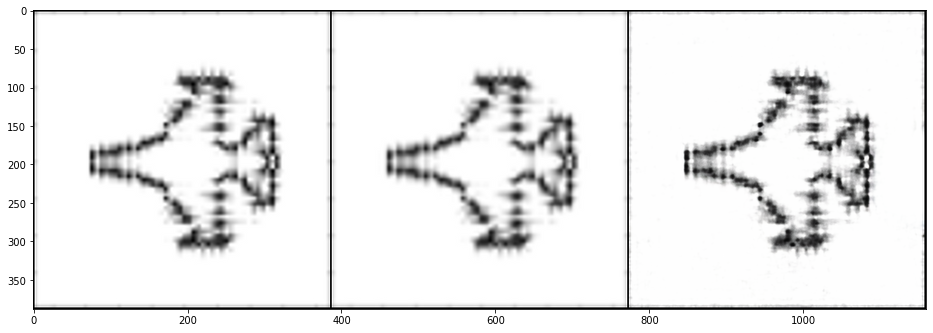

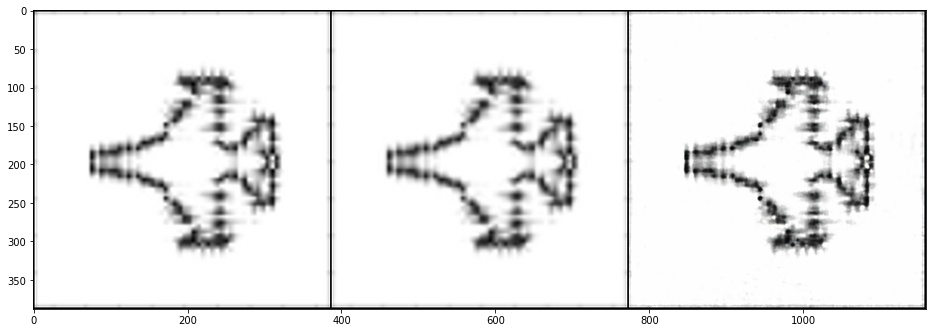

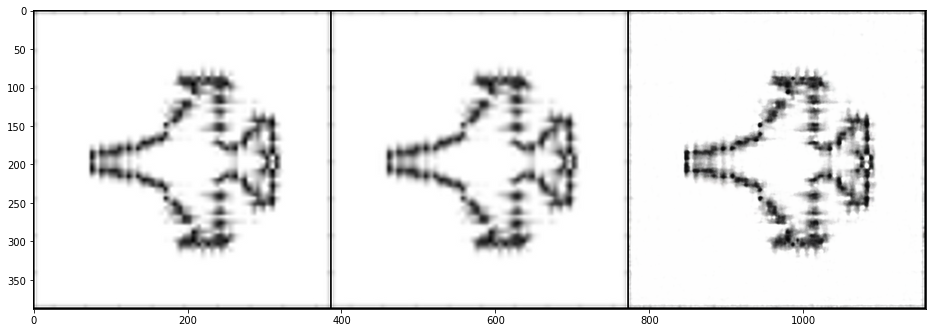

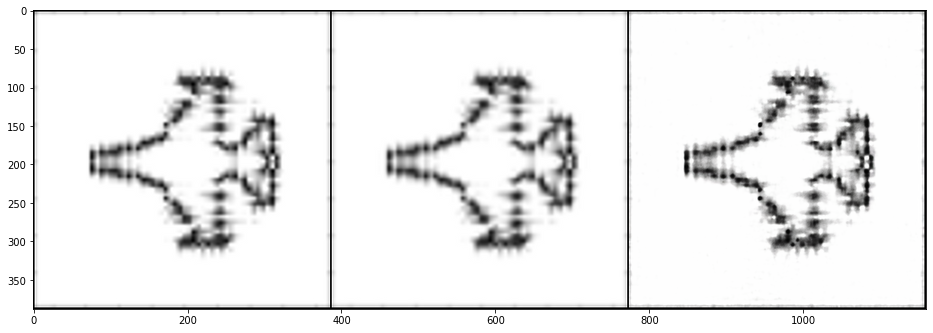

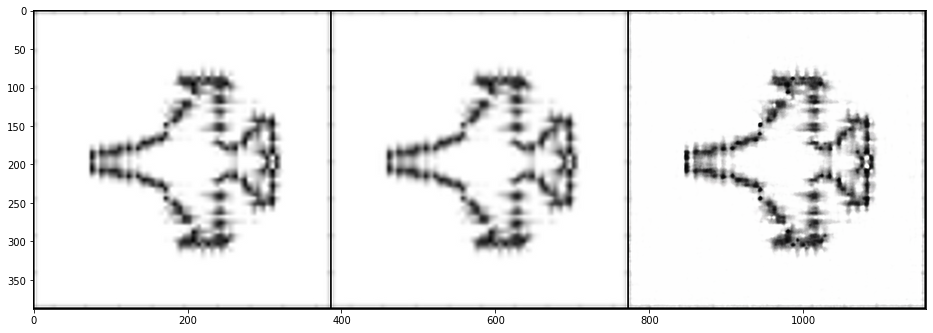

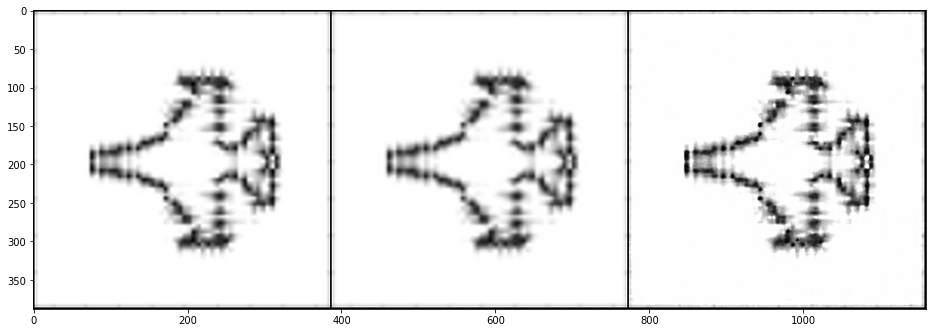

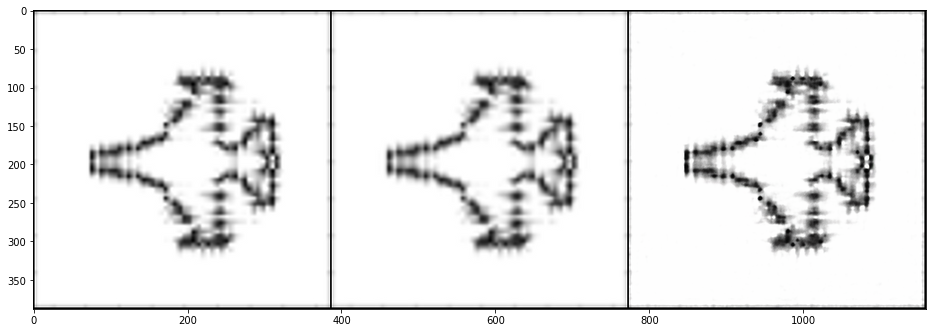

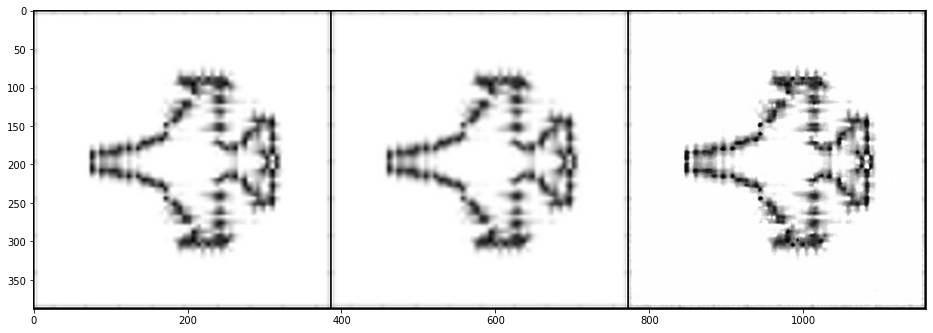

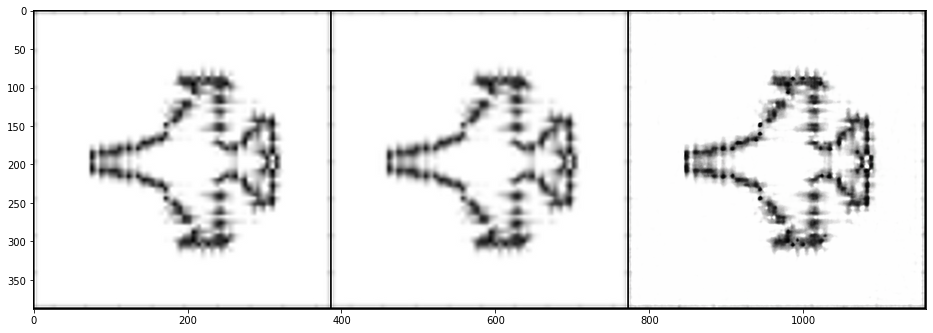

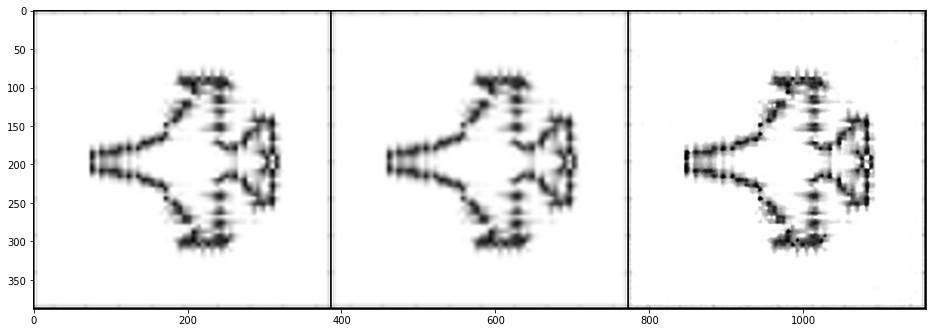

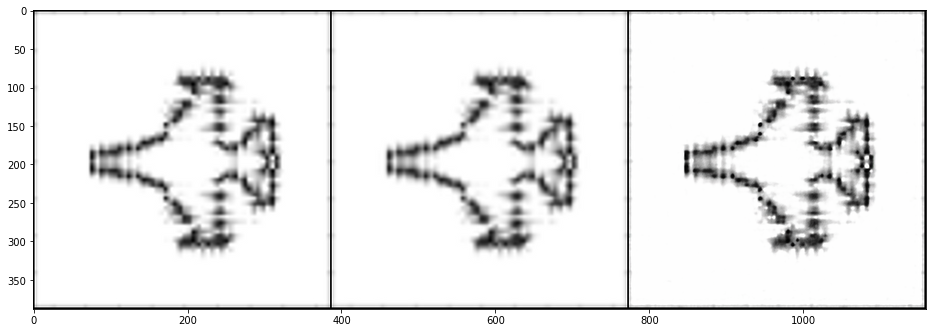

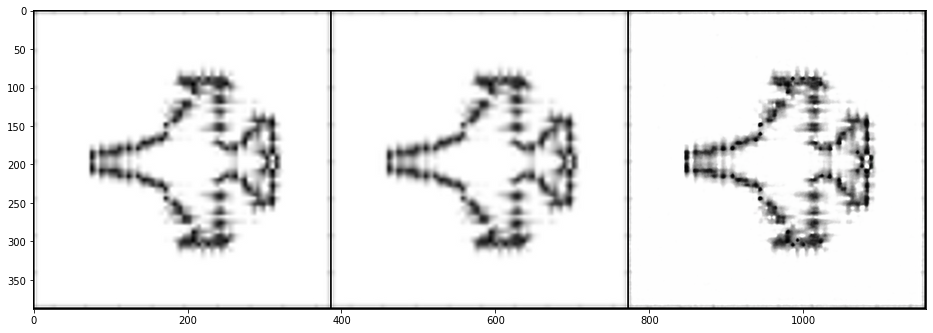

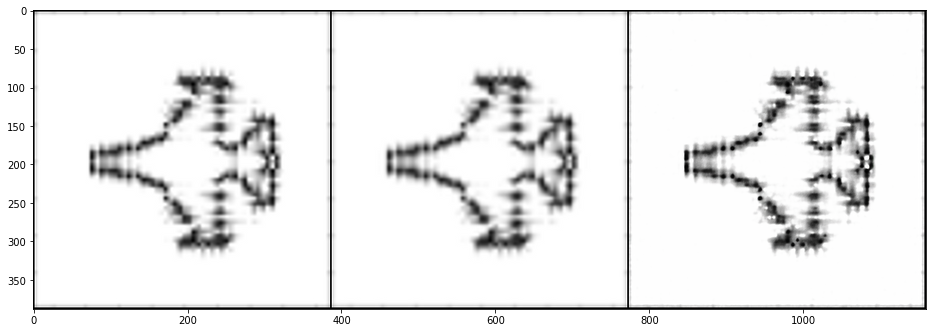

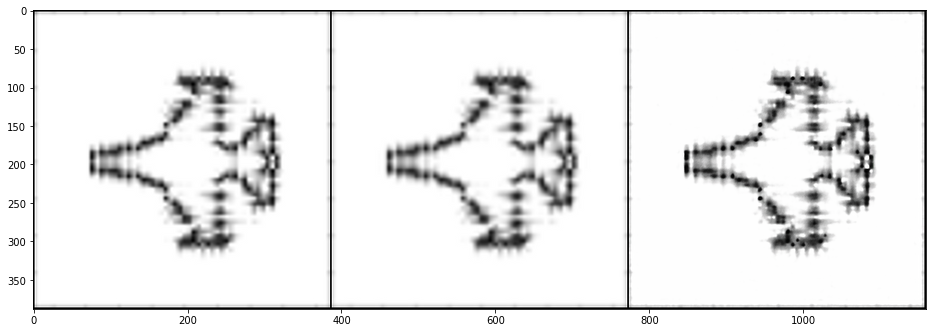

In [61]:
psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


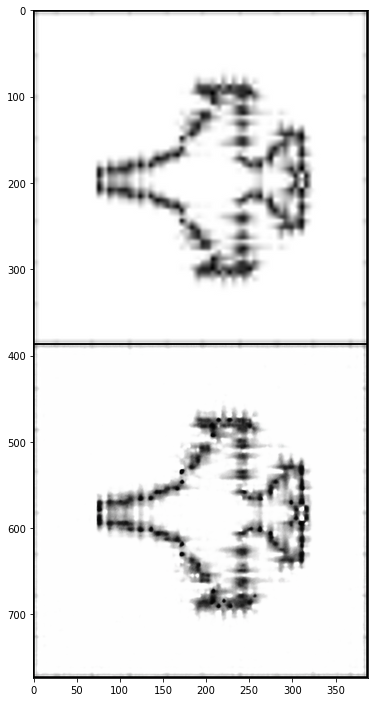

In [62]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])

# For the paper we acually took `_bicubic.png` files from LapSRN viewer and used `result_deep_prior` as our result
imggg = plot_image_grid([imgs['HR_np'],
                 #imgs['bicubic_np'],
                 out_HR_np], factor=4, nrow=1);
               

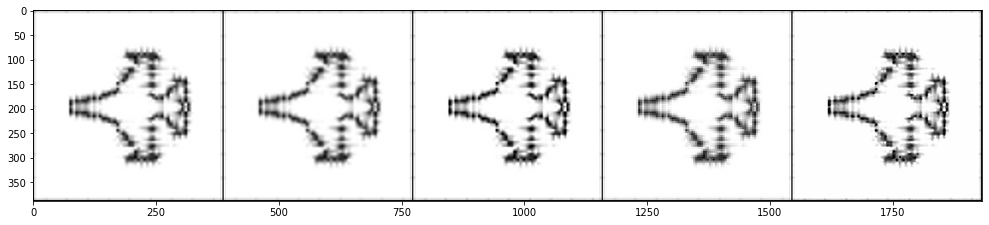

PSNR bicubic: 40.8003   PSNR nearest: 29.9417 PSNR sharp: 33.9962 PSNR: 31.1644


In [63]:
if PLOT:
    plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'], out_HR_np], 5,12);
    print ('PSNR bicubic: %.4f   PSNR nearest: %.4f PSNR sharp: %.4f PSNR: %.4f' %  (
                                        peak_signal_noise_ratio(imgs['HR_np'], imgs['bicubic_np']), 
                                        peak_signal_noise_ratio(imgs['HR_np'], imgs['nearest_np']),
                                        peak_signal_noise_ratio(imgs['HR_np'], imgs['sharp_np']),
                                        peak_signal_noise_ratio(imgs['HR_np'], out_HR_np)))

In [64]:
print(*psnr_history)

[6.852468357435576, 6.86421312753156] [8.209581291050942, 8.236141219360789] [9.93302426196501, 9.974707079608558] [10.96163701115033, 11.013244391666976] [13.396780144757866, 13.48360409985826] [14.919269435760455, 15.038940039925135] [15.588975910121533, 15.726142397303667] [15.959466200579708, 16.107279587685742] [16.26774806619851, 16.42643265589062] [16.651125504312652, 16.82502975208608] [17.104796965524404, 17.298878565257333] [16.926096723332865, 17.11058999334538] [17.18569114483692, 17.382988324560486] [17.165687149003183, 17.362446358594084] [17.46878475036659, 17.67615416840887] [17.071776368220245, 17.25979730273856] [17.76532186870891, 17.987905394991582] [17.759261511730323, 17.985696754552833] [17.69957391714656, 17.922444751808214] [17.902337437784237, 18.13288792201454] [17.86074427127886, 18.086554555298974] [17.769973727018098, 17.992546539987682] [18.060030295409202, 18.29677012914081] [18.213281983173133, 18.45665130487656] [18.412106255810695, 18.66624160815395] 

In [65]:
print ('PSNR : %.4f' %  (peak_signal_noise_ratio(imgs['bicubic_np'], out_HR_np)))

print ('PSNR : %.4f' %  (peak_signal_noise_ratio(imgs['sharp_np'], out_HR_np)))

print ('PSNR : %.4f' %  (peak_signal_noise_ratio(imgs['nearest_np'], out_HR_np)))

print ('PSNR : %.4f' %  (peak_signal_noise_ratio(imgs['HR_np'], imgs['bicubic_np'])))

PSNR : 29.2501
PSNR : 30.9444
PSNR : 26.8092
PSNR : 40.8003


In [66]:
path_to_image_2 = 'data/sr/smallbw_384.png'
imgs = load_LR_HR_imgs_sr(path_to_image_2, imsize, factor, enforse_div32)
print ('PSNR : %.4f' %  (peak_signal_noise_ratio(imgs['orig_np'], out_HR_np)))

HR and LR resolutions: (384, 384), (96, 96)
PSNR : 24.9092
